In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv("../../dataset/HBAN.csv")
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
X = df[['Open']]
df = df[['Close']]


# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

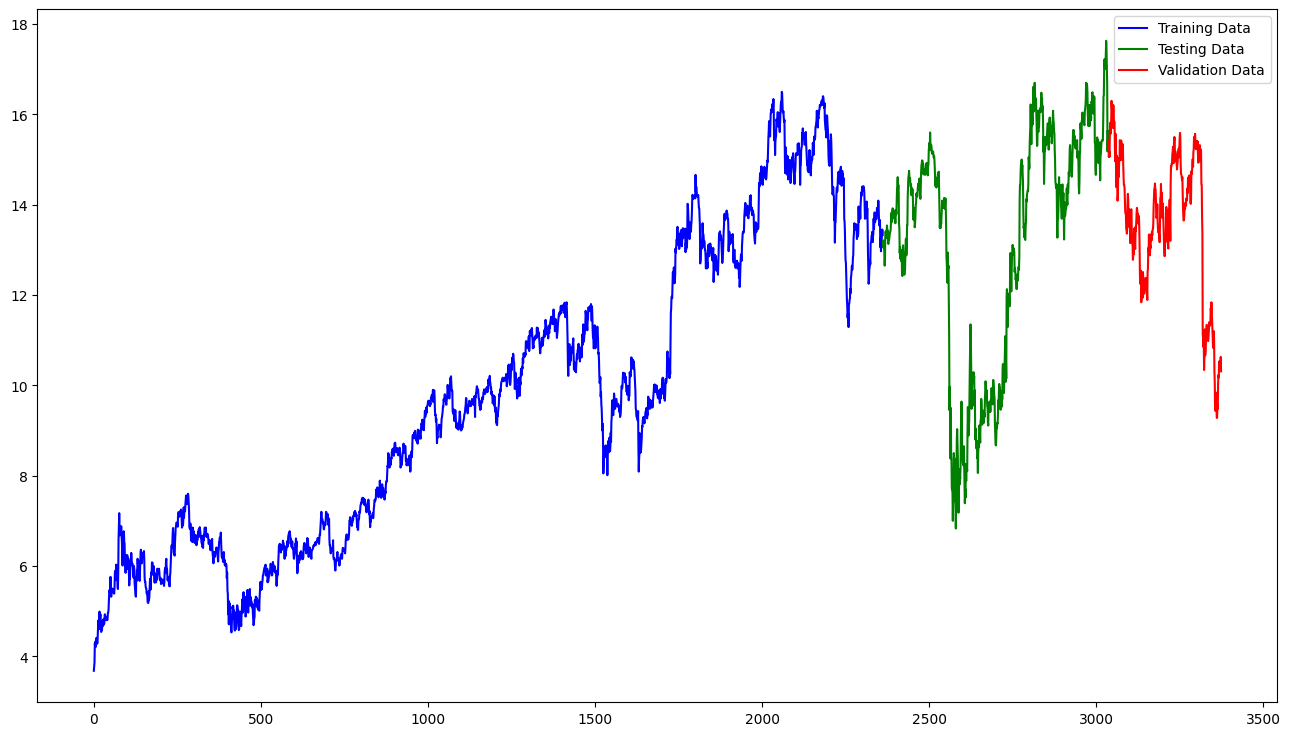

In [3]:
#Trực quan các tệp dữ liệu vừa chia
plt.figure(figsize=(16,9))
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.plot(val_data, 'red', label='Validation Data')
plt.legend()

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=X[:train_size], 
                   start_p=1, start_q=1, 
                   test='adf',
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, 
                   d=None, D=1, trace=True, 
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3805.249, Time=0.30 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1057.375, Time=2.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1763.893, Time=2.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3820.716, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-443.357, Time=0.93 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-1298.804, Time=9.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=19.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3760.626, Time=3.15 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-1297.146, Time=9.70 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-1297.103, Time=10.08 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1734.841, Time=6.94 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-1298.747, Time=14.79 sec
 ARIMA(1,0,0)(2,1,0)[12]  

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))


In [6]:
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))


In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[13.17373402 13.16674234 13.27716644 13.29738942 13.10508524 13.13320507
 13.14460498 13.23773617 13.32341452 13.3507453  13.51822354 13.4953126
 13.27625683 13.2548093  13.36200856 13.38668891 13.10907969 13.21038133
 13.18560028 13.2871688  13.2920899  13.39415192 13.54908243 13.46536318
 13.24300574 13.20292197 13.29438003 13.33949747 12.99179648 13.1043586 ]


In [8]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)
print('Validation MAPE:', valid_mape)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Validation RMSE: 1.6474864820906963
Validation MAE: 1.3816785007594516
Validation MAPE: 10.538749078178295
Testing RMSE: 2.614747184508921
Testing MAE: 2.1814676729402565
Testing MAPE: 19.18891419527318


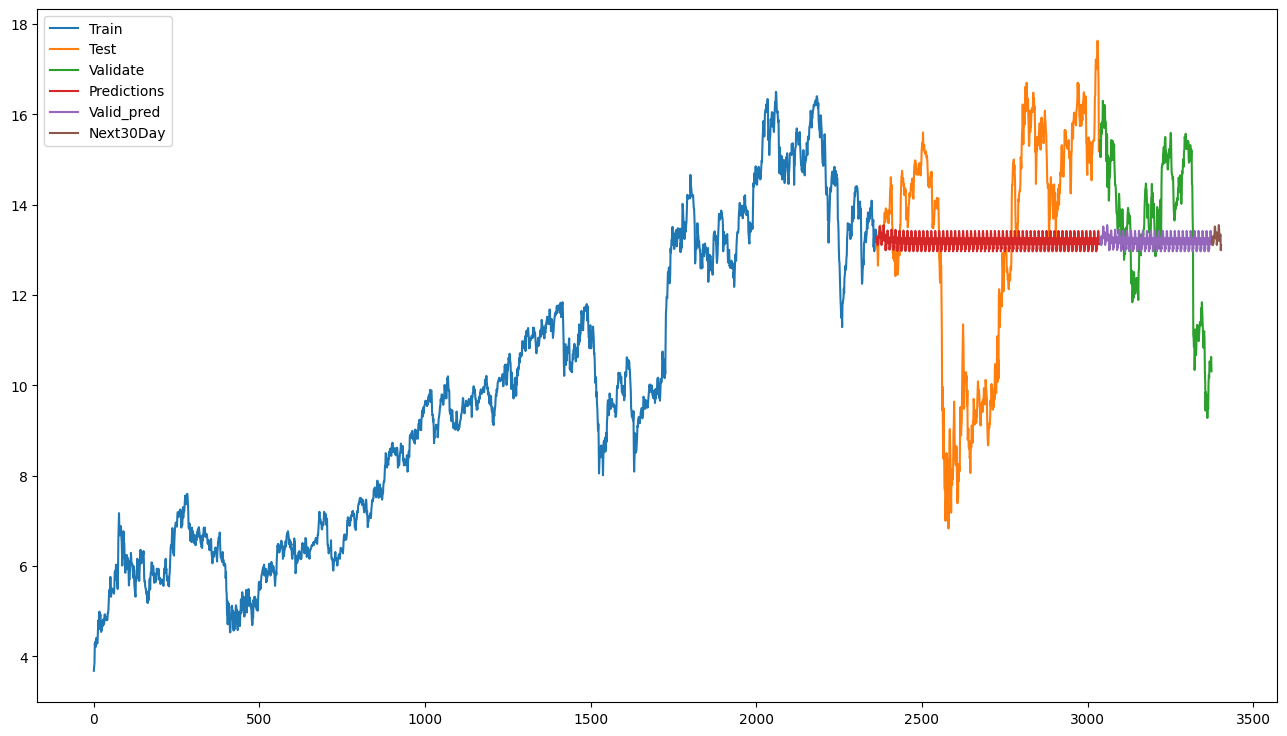

In [9]:
# 9.Vẽ hình
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Valid_pred','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=2362, stop=3037, step=1)